In [1]:
import requests
from torch.utils.data import Dataset, DataLoader
import zipfile
import pandas as pd
import os
import torch
import io
import numpy as np
from torchvision.io import read_image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [27]:
train_images_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip"
test_images_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip"
train_gt_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv"
test_gt_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv"

In [28]:
a = requests.get(train_images_url, allow_redirects=True)
print('a-requested')
with open('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Training_Data.zip','wb') as f:
    f.write(a.content)
b = requests.get(test_images_url, allow_redirects=True)
print('b-requested')
with open('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_Data.zip','wb') as f:
    f.write(b.content)
c = requests.get(train_gt_url, allow_redirects=True)
print('c-requested')
with open('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Training_GroundTruth.csv','wb') as f:
    f.write(c.content)
d = requests.get(test_gt_url, allow_redirects=True)
print('d-requested')
with open('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_GroundTruth.csv','wb') as f:
    f.write(d.content)

ConnectionError: HTTPSConnectionPool(host='isic-challenge-data.s3.amazonaws.com', port=443): Max retries exceeded with url: /2016/ISBI2016_ISIC_Part3_Training_Data.zip (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000018081A5F590>: Failed to resolve 'isic-challenge-data.s3.amazonaws.com' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
with zipfile.ZipFile('ISBI2016_ISIC_Part3_Training_Data.zip','r') as f:
    f.extractall()
with zipfile.ZipFile('ISBI2016_ISIC_Part3_Test_Data.zip', 'r') as f:
    f.extractall()

In [2]:
class MelanomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmark_frame = pd.read_csv(csv_file,names=['img_name', 'class'])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmark_frame)

        # Normalization of images as described in the paper
    def normalize(self,image):
        image[0,:,:] = (image[0,:,:]-torch.mean(image[0,:,:].float()))/torch.std(image[0,:,:].float())
        image[1,:,:] = (image[1,:,:]-torch.mean(image[1,:,:].float()))/torch.std(image[1,:,:].float())
        image[2,:,:] = (image[2,:,:]-torch.mean(image[2,:,:].float()))/torch.std(image[2,:,:].float())
        return image
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        classes = {'malignant':1.0, 'benign':0.0}
        img_name = os.path.join(self.root_dir, self.landmark_frame.iloc[idx, 0]+'.jpg').replace('\\','/')
        label = self.landmark_frame.iloc[idx, 1]
        image = read_image(img_name)
        if self.transform:
            sample = [image, classes[label]]
        else:
            sample = [image,label]
        
        if self.transform:
            sample[0] = self.transform(sample[0])
        else:
            transform2 = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224,224)),
                transforms.ToTensor()
                ])
            sample[0] = transform2(sample[0])

        sample[0] = self.normalize(sample[0])
        return sample


In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

In [4]:
melanoma_dataset = MelanomaDataset('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 'D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Training_Data',transform=transform)

In [5]:
batch_size = 8
dataloader = DataLoader(melanoma_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


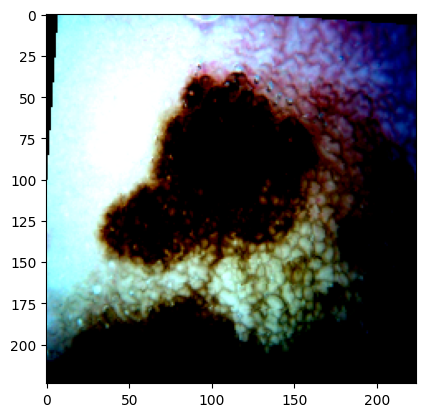

In [6]:
# out_img2 = melanoma_dataset[899]['image'].permute(1,2,0).detach().numpy()
out_img2 = melanoma_dataset[899][0].permute(1,2,0).numpy()
# out_img2=out_img.detach().numpy()
# arr_ = np.squeeze(out_img2)
# plt.imshow(arr_)
plt.imshow(out_img2)
plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
model.fc = nn.Linear(2048,1, bias=False)
model = model.to(device)

In [ ]:
print(model)

In [ ]:
# Training the whole model on our dataset

epochs = 1
learning_rate = 1e-5

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(epochs):
    for idx, (img, label) in enumerate(dataloader):
        img = img.to(device)
        label = torch.Tensor(label)
        label = label.unsqueeze(1).to(device)

        # forward pass
        y_pred = model(img)
        loss = criterion(y_pred, label)

        # backward pass
        loss.backward()

        # weight update
        optimizer.step()

        # making gradint zero
        optimizer.zero_grad()

In [43]:
PATH = './MelanomaResNet50'

In [44]:
model = resnet50()
model.fc = nn.Linear(2048, 1, bias=False)
model = model.to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [45]:
# melanoma_dataset_test = MelanomaDataset('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 'D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_Data')
melanoma_dataset_test = MelanomaDataset('D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 'D:/Vimal/1A_pytorch/melanoma/ISBI2016_ISIC_Part3_Test_Data')

In [46]:
# batch_size = 8
dataloader_test = DataLoader(melanoma_dataset_test, batch_size=batch_size, shuffle=False)

In [47]:
melanoma_dataset_test[1][0].shape

torch.Size([3, 224, 224])

In [48]:
# Accuracy 
correct = 0
total = 0

with torch.no_grad():
    for (image, label) in dataloader_test:
        image = image.to(device)
        label = torch.Tensor(label).unsqueeze(1).to(device)

        prediction = model(image)

        total += label.size(0)
        correct +=  (prediction==label).sum().item()

print(f'The Accuracy of the model is {100*correct/total}')

The Accuracy of the model is 0.0


In [49]:
intermediate_output = []

# Define a hook function
def hook_fn(module, input, output):
    intermediate_output.append(output.detach().numpy())

# Register the hook to the desired layer
# For example, registering to the first convolutional layer
hook = model.avgpool.register_forward_hook(hook_fn)

In [50]:
intermediate_output = []
X = []
y = []
with torch.no_grad():
    for (image, label) in dataloader:
        image = image.to(device)
        label = torch.Tensor(label).unsqueeze(1).to(device)

        prediction = model(image)

        for inter_y in label:
            y.append(inter_y)

# print(f'The Accuracy of the model is {100*correct/total}')

In [51]:
for inter in intermediate_output:
    for i in inter:
        X.append(i.squeeze())

In [52]:
X = np.array(X)
y = np.array(y).squeeze()

In [53]:
intermediate_output = []
X_test = []
y_test = []
with torch.no_grad():
    for (image, label) in dataloader_test:
        image = image.to(device)
        label = torch.Tensor(label).unsqueeze(1).to(device)

        prediction = model(image)

        for inter_y in label:
            y_test.append(inter_y)


In [54]:
for inter in intermediate_output:
    for i in inter:
        X_test.append(i.squeeze())

In [55]:
X_test = np.array(X_test)
y_test = np.array(y_test).squeeze()

In [56]:
print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(900, 2048) (900,)
(379, 2048) (379,)


In [73]:
from discriminant_analysis import Discriminant
from lda import LDA
dis = Discriminant(4,1)
lda = LDA(4)
dis.fit(X, y)
lda.fit(X,y)

727
173


In [74]:
X_projected = lda.transform(X)

In [75]:
from sklearn import svm
clf = svm.SVC()

In [76]:
clf.fit(X_projected,y)

SVC()

In [83]:
## Trainig dataset Accuracy
correct = 0

y_pred = clf.predict(X_projected)

(y_pred==y).sum().item()/len(y)

# print(f'Total Accuracy = {100*correct/len(y_pred) }')

0.8166666666666667

In [81]:
X_projected_test = lda.transform(X_test)

In [88]:
## Test dataset Accuracy
correct = 0

y_pred = clf.predict(X_projected_test)

(y_pred==y_test).sum().item()/len(y_test)

0.8047493403693932

In [89]:
y = y_test

In [90]:
tp = 0
fn = 0
for i in range(len(y)):
    if y[i]==y_pred[i]:
        tp+=1
    if y[i]==1 and y_pred[i]==0:
        fn+=1
        


In [91]:
print(tp)

305


In [92]:
print(tp/(tp+fn))

0.8068783068783069
